In [6]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')


import pandas as pd
import numpy as np
import time
import json
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, HTML
%matplotlib notebook


# Season simulations
The final section of the tutorial covers the generation of competition-level predictions. These are produced by aggregating match-level predictions using a Monte Carlo simulation algorithm. Below is a step-by-step explanation of the process followed:

1. Get exact score predictions (leveraging the model in section 2) for all games in the season that have not yet ended (“playing” or “to be played”). Each of these predictions is a 2-D probability mass function that contains the estimated probabilities of every possible result.


2. Sample _N_ times from each of these PMF estimates. This gives _N_ simulated exact score outcomes for every game (_N_ "simulation runs").


3. For any given team _T_, we now have _N_ simulated outcomes for _M_ games (the _M_ games left to be played that involve team _T_). We can add up the number of points that team _T_ gets in each simulation run. This leaves us with _N_ samples of the remaining number of points that team _T_ gets in what’s left of the season, which we can use as an approximation of the true underlying probability mass function (PMF). The larger _N_ we use in this sampling step, the smoother the PMF will be, but the longer it’ll take to run the simulation.


4. Then we must incorperate the tie-breaking procedure

# Tie-Breaking Procedure

## To Break A Tie Within A Division
If, at the end of the regular season, two or more clubs in the same division finish with identical won-lost-tied percentages, the following steps will be taken until a champion is determined.

### Two Clubs
1. Head-to-head (best won-lost-tied percentage in games between the clubs).
2. Best won-lost-tied percentage in games played within the division.
3. Best won-lost-tied percentage in common games.
4. Best won-lost-tied percentage in games played within the conference.
5. Strength of victory. (probably the end)
6. Strength of schedule. (definitely the end)
7. Best combined ranking among conference teams in points scored and points allowed.
8. Best combined ranking among all teams in points scored and points allowed.
9. Best net points in common games.
10. Best net points in all games.
11. Best net touchdowns in all games.
12. Coin toss

### Three or More Clubs
(Note: If two clubs remain tied after third or other clubs are eliminated during any step, tie breaker reverts to step 1 of the two-club format).

1. Head-to-head (best won-lost-tied percentage in games among the clubs).
2. Best won-lost-tied percentage in games played within the division.
3. Best won-lost-tied percentage in common games.
4. Best won-lost-tied percentage in games played within the conference.
5. Strength of victory.
6. Strength of schedule.
7. Best combined ranking among conference teams in points scored and points allowed.
8. Best combined ranking among all teams in points scored and points allowed.
9. Best net points in common games.
10. Best net points in all games.
11. Best net touchdowns in all games.
12. Coin toss



## To Break A Tie For The Wild-Card Team
If it is necessary to break ties to determine the two Wild-Card clubs from each conference, the following steps will be taken.

If the tied clubs are from the same division, apply division tie breaker.
If the tied clubs are from different divisions, apply the following steps.
### Two Clubs
1. Head-to-head, if applicable.
2. Best won-lost-tied percentage in games played within the conference.
3. Best won-lost-tied percentage in common games, minimum of four.
4. Strength of victory.
5. Strength of schedule.
6. Best combined ranking among conference teams in points scored and points allowed.
7. Best combined ranking among all teams in points scored and points allowed.
8. Best net points in conference games.
9. Best net points in all games.
10. Best net touchdowns in all games.
11. Coin toss.

### Three or More Clubs
(Note: If two clubs remain tied after third or other clubs are eliminated, tie breaker reverts to step 1 of applicable two-club format.)

1. Apply division tie breaker to eliminate all but the highest ranked club in each division prior to proceeding to step 2. The original seeding within a division upon application of the division tie breaker remains the same for all subsequent applications of the procedure that are necessary to identify the two Wild-Card participants.
2. Head-to-head sweep. (Applicable only if one club has defeated each of the others or if one club has lost to each of the others.)
3. Best won-lost-tied percentage in games played within the conference.
4. Best won-lost-tied percentage in common games, minimum of four.
5. Strength of victory.
6. Strength of schedule.
7. Best combined ranking among conference teams in points scored and points allowed.
8. Best combined ranking among all teams in points scored and points allowed.
9. Best net points in conference games.
10. Best net points in all games.
11. Best net touchdowns in all games.
12. Coin toss


In [7]:
def aggregate_match_results_by_team(results, team_names, return_detail=False):

    results_df = pd.DataFrame(results)
    results_df['outcome'] = np.sign(results_df['home_score'] - results_df['away_score']) + 1
    home_df = results_df[['home_team_id', 'away_team_id', 'game_code', 'outcome', 'home_score', 'away_score']]\
        .rename(columns={'home_team_id': 'team_id', 'away_team_id': 'opponent_id', 'home_score': 'GF', 'away_score': 'GA'})
    home_df['is_home'] = 1
    away_df = results_df[['away_team_id', 'home_team_id', 'game_code', 'outcome', 'home_score', 'away_score']]\
        .rename(columns={'away_team_id': 'team_id', 'home_team_id': 'opponent_id', 'away_score': 'GF', 'home_score': 'GA'})
    away_df['outcome'] = away_df['outcome'].map({0: 2, 1: 1, 2: 0})
    away_df['is_home'] = 0
    results_df = pd.concat([home_df, away_df], axis=0)
    
    results_df = results_df.merge(team_names[["division_id", "conference_id"]], left_on="team_id", right_index=True, sort=False)
    results_df = results_df.merge(team_names[["division_id", "conference_id"]], left_on="opponent_id", right_index=True, sort=False, suffixes=["_team", "_opponent"])

    results_df['G'] = 1
    results_df['W'] = (results_df['outcome'] == 2).astype(int)
    results_df['D'] = (results_df['outcome'] == 1).astype(int)
    results_df['L'] = (results_df['outcome'] == 0).astype(int)
    
    results_df['points'] = results_df['outcome']
    results_df['GF_away'] = results_df['GF'].where(results_df['is_home'] == 0, 0)

    results_df['points_conference'] = results_df['points'].where(results_df["conference_id_team"]==results_df["conference_id_opponent"], 0)
    results_df['points_division'] = results_df['points'].where((results_df["conference_id_team"]==results_df["conference_id_opponent"])& (results_df["division_id_team"]==results_df["division_id_opponent"]), 0)

    results_df['games_conference'] = results_df['G'].where(results_df["conference_id_team"]==results_df["conference_id_opponent"], 0)
    results_df['games_division'] = results_df['G'].where((results_df["conference_id_team"]==results_df["conference_id_opponent"])& (results_df["division_id_team"]==results_df["division_id_opponent"]), 0)
    agg_df = results_df.groupby('team_id')[['G', 'W', 'D', 'L', 'points', 'GF', 'GA', 'GF_away', 'points_conference', 'points_division', 'games_conference', 'games_division']].sum()
    if return_detail:
        return agg_df, results_df
    else:
        return agg_df
    
def simulate_season_standing_with_tiebreakers(match_preds, match_results, team_names, pred_params, n_runs):
    team_names = pd.DataFrame(team_names).set_index('id')[['name', 'conference_id', 'division_id']]
    start_time = time.time()
    print('Simulating season ({0:d} runs)'.format(n_runs))
    run_list = []
    no_games_left = len(match_preds) == 0
    for match in match_preds:
        exact_score_probs = np.array(match['pred_exact_score']) / np.sum(match['pred_exact_score'])
        scores = np.random.multinomial(
            n=1,
            pvals=exact_score_probs,
            size=n_runs
        )
        ind_scores = np.argmax(scores, axis=1)
        aux_home = np.tile(np.arange(0, pred_params['max_home_score'] + 1), (pred_params['max_away_score'] + 1, 1)).flatten(order='F')
        aux_away = np.tile(np.arange(0, pred_params['max_away_score'] + 1), (pred_params['max_home_score'] + 1))
        home_scores = aux_home[ind_scores] + match['current_score'][0]
        away_scores = aux_away[ind_scores] + match['current_score'][1]
        away_outcomes = np.zeros((n_runs, 3)).astype(int)
        away_outcomes[np.arange(n_runs), np.sign(home_scores - away_scores) + 1] = 1
        home_outcomes = np.fliplr(away_outcomes)

        home_df = pd.DataFrame(
            data=np.hstack((np.arange(1, n_runs + 1).reshape(-1, 1), home_outcomes, home_scores.reshape(-1, 1), away_scores.reshape(-1, 1))),
            columns=['run', 'W', 'D', 'L', 'GF', 'GA']
        )
        # home_df = home_df.merge(team_names)
        home_df['team_id'] = match['home_team_id']
        home_df['opponent_id'] = match['away_team_id']
        home_df['is_home'] = 1
        away_df = pd.DataFrame(
            data=np.hstack((np.arange(1, n_runs + 1).reshape(-1, 1), away_outcomes, away_scores.reshape(-1, 1), home_scores.reshape(-1, 1))),
            columns=['run', 'W', 'D', 'L', 'GF', 'GA']
        )
        away_df['team_id'] = match['away_team_id']
        away_df['opponent_id'] = match['home_team_id']
        away_df['is_home'] = 0
        run_df = pd.concat([home_df, away_df], axis=0)
        run_df = run_df.merge(team_names[["division_id", "conference_id"]], left_on="team_id", right_index=True, sort=False)
        run_df = run_df.merge(team_names[["division_id", "conference_id"]], left_on="opponent_id", right_index=True, sort=False, suffixes=["_team", "_opponent"])
        run_list.append(run_df)

    if no_games_left:
        empty_run_df_cols = ['run', 'team_id', 'opponent_id', 'W', 'D', 'L', 'GF', 'GA', 'is_home', 'G', 'points', 'GF_away']
        all_runs_df = pd.DataFrame({col: pd.Series([], dtype='str' if col in ['team_id', 'opponent_id'] else 'int64') for col in empty_run_df_cols})
        missing_team_ids = team_names.index.unique()
    else:
        all_runs_df = pd.concat(run_list, axis=0).reset_index(drop=True)
        all_runs_df['G'] = 1
        all_runs_df['points'] = (all_runs_df[['W', 'D', 'L']] * np.array([2, 1, 0])).sum(axis=1)
        all_runs_df['points_conference'] = all_runs_df['points'].where(all_runs_df["conference_id_team"]==all_runs_df["conference_id_opponent"], 0)
        all_runs_df['points_division'] = all_runs_df['points'].where((all_runs_df["conference_id_team"]==all_runs_df["conference_id_opponent"])& (all_runs_df["division_id_team"]==all_runs_df["division_id_opponent"]), 0)

        all_runs_df['games_conference'] = all_runs_df['G'].where(all_runs_df["conference_id_team"]==all_runs_df["conference_id_opponent"], 0)
        all_runs_df['games_division'] = all_runs_df['G'].where((all_runs_df["conference_id_team"]==all_runs_df["conference_id_opponent"])& (all_runs_df["division_id_team"]==all_runs_df["division_id_opponent"]), 0)
        all_runs_df['GF_away'] = all_runs_df['GF'].where(all_runs_df['is_home'] == 0, 0)
        # Aggregate simulated game results by run
        agg_runs_df = all_runs_df.drop(columns='opponent_id').groupby(['run', 'team_id']).sum().reset_index(drop=False)
        missing_team_ids = np.setdiff1d(team_names.index, agg_runs_df.team_id)
        
    # Ranking criteria
    ranking_criteria = ['points', 'H2H_points', 'points_division', 'points_conference', 'GD', 'GF', 'H2H_GF_away']
    
    # Preliminary criteria (anything that does not involve head-to-head subsetting)
    preliminary_criteria = []
    for i in ranking_criteria:
        if i.find('H2H_') == 0:
            break
        else:
            preliminary_criteria.append(i)

    # Aggregate previous results
    agg_match_results, match_team_results = aggregate_match_results_by_team(match_results, team_names, return_detail=True)

    # Add missing teams (teams present in observed results but without any remaining games)
    if missing_team_ids.size > 0:
        aux_ind = pd.MultiIndex.from_product([np.arange(1, n_runs + 1), missing_team_ids], names=['run', 'team_id'])
        missing_df = pd.DataFrame(columns=np.setdiff1d(all_runs_df.columns, ['run', 'team_id', 'opponent_id']).tolist(),
                                  data=0, index=aux_ind).reset_index(drop=False)
        if no_games_left:
            agg_runs_df = missing_df
        else:
            agg_runs_df = pd.concat([agg_runs_df, missing_df], axis=0)

    # Add observed results from past games
    sum_cols = ['G', 'W', 'D', 'L', 'GF', 'GA', 'points', 'GF_away', 'points_conference', 'points_division', 'games_conference', 'games_division']
    prev_df = agg_match_results.reindex(agg_runs_df.team_id.values, columns=sum_cols).fillna(0).astype(int)
    agg_runs_df[sum_cols] = agg_runs_df[sum_cols].values + prev_df.values
    agg_runs_df['GD'] = agg_runs_df['GF'] - agg_runs_df['GA']
    agg_runs_df = agg_runs_df.sort_values(by=['run'] + preliminary_criteria, ascending=False).reset_index(drop=True)

    # Identify ties (2 or more teams with identical values in the (preliminary) sorting features)
    aux = agg_runs_df.drop_duplicates(subset=['run'] + preliminary_criteria).index.values
    agg_runs_df['tie_id'] = 0
    agg_runs_df.loc[aux, 'tie_id'] = 1
    agg_runs_df['tie_id'] = np.cumsum(agg_runs_df['tie_id'])
    tie_size = agg_runs_df.groupby(['tie_id'])['team_id'].count().rename('tie_size').reset_index(drop=False)
    agg_runs_df = agg_runs_df.merge(right=tie_size, on='tie_id', how='left')


    agg_runs_df =agg_runs_df.merge(team_names, left_on=["team_id"], right_index=True, how="left")
    agg_runs_df["division_id_unique"] = agg_runs_df["conference_id"] * 10 + agg_runs_df["division_id"]

    agg_runs_df = agg_runs_df.sort_values(['run', 'division_id_unique'] + preliminary_criteria)
    aux_division = agg_runs_df.drop_duplicates(subset=['run', 'division_id_unique'] + preliminary_criteria).index.values
    agg_runs_df['division_tie_id'] = 0
    agg_runs_df.loc[aux_division, 'division_tie_id'] = 1
    agg_runs_df['division_tie_id'] = np.cumsum(agg_runs_df['division_tie_id'])
    tie_size_division = agg_runs_df.groupby(['division_tie_id'])['team_id'].count().rename('division_tie_size').reset_index(drop=False)
    agg_runs_df = agg_runs_df.merge(right=tie_size_division, on='division_tie_id', how='left')
    agg_runs_df_tie_values = agg_runs_df

    agg_runs_df = agg_runs_df.sort_values(['run', 'conference_id'] + preliminary_criteria)
    aux_conference = agg_runs_df.drop_duplicates(subset=['run', 'conference_id'] + preliminary_criteria).index.values
    agg_runs_df['conference_tie_id'] = 0
    agg_runs_df.loc[aux_conference, 'conference_tie_id'] = 1
    agg_runs_df['conference_tie_id'] = np.cumsum(agg_runs_df['conference_tie_id'])
    tie_size_conference = agg_runs_df.groupby(['conference_tie_id'])['team_id'].count().rename('conference_tie_size').reset_index(drop=False)
    agg_runs_df = agg_runs_df.merge(right=tie_size_conference, on='conference_tie_id', how='left')
    agg_runs_df_tie_values = agg_runs_df


    # Head-to-head data
    h2h_df = agg_runs_df[['run', 'tie_id', 'division_tie_id', 'conference_tie_id', 'team_id']]
    h2h_df = h2h_df.merge(right=h2h_df, on=['run', 'tie_id', 'division_tie_id', 'conference_tie_id'], how='left')
    h2h_df = h2h_df.loc[h2h_df.team_id_x != h2h_df.team_id_y]
    h2h_df.rename(columns={'team_id_x': 'team_id', 'team_id_y': 'opponent_id'}, inplace=True)
    # Relevant results
    h2h_past_df = h2h_df.merge(
        right=match_team_results[['team_id', 'opponent_id', 'is_home'] + sum_cols],
        on=['team_id', 'opponent_id'],
        how='inner'
    )
    # Relevant simulations
    h2h_pred_df = h2h_df.merge(
        right=all_runs_df[['run', 'team_id', 'opponent_id', 'is_home'] + sum_cols],
        on=['run', 'team_id', 'opponent_id'],
        how='inner'
    )
    # Join results and predictions
    h2h_df = pd.concat([h2h_past_df, h2h_pred_df], axis=0).reset_index(drop=True)
    h2h_df['GD'] = h2h_df['GF'] - h2h_df['GA']
    h2h_df['GF_away'] = h2h_df['GF'].where(h2h_df['is_home'] == 0, 0)
    h2h_df.drop(columns='opponent_id', inplace=True)
    # Aggregate "head-to-head runs"
    agg_h2h_df = h2h_df.groupby(['run', 'tie_id', 'division_tie_id', 'conference_tie_id', 'team_id']).sum().reset_index(drop=False)
    agg_h2h_df.rename(columns={i: 'H2H_' + i for i in ['points', 'GD', 'GF', 'GF_away']}, inplace=True)

    # Add tie breaker values to the main data frame
    h2h_cols = [i for i in agg_h2h_df.columns if i.find('H2H_') == 0]
    agg_runs_df = agg_runs_df.merge(
        right=agg_h2h_df[['run', 'tie_id', 'division_tie_id', 'conference_tie_id', 'team_id'] + h2h_cols],
        on=['run', 'tie_id', 'division_tie_id', 'conference_tie_id', 'team_id'],
        how='left'
    )
    agg_runs_df[h2h_cols] = agg_runs_df[h2h_cols].fillna(0)

    # Sort main data frame again, now with all tie-breaking data included

    agg_runs_df = agg_runs_df.sort_values(by=['run'] + ranking_criteria, ascending=False).reset_index(drop=True)

    # Calculate rank ("cheap" method, repeating a [1, 2, 3, ..., N] array as many times as runs)
    agg_runs_df['rank'] = np.arange(1, team_names.size/3 + 1).tolist() * n_runs

    agg_runs_df = agg_runs_df.sort_values(by=['run'] + ["conference_id"] + ranking_criteria, ascending=False).reset_index(drop=True)
    agg_runs_df['conference_rank'] = np.arange(1, team_names.size/3 / 2 + 1).tolist() * n_runs * 2
    
    agg_runs_df = agg_runs_df.sort_values(by=['run'] + ["division_id_unique"] + ranking_criteria, ascending=False).reset_index(drop=True)
    agg_runs_df['division_rank'] = np.arange(1, team_names.size/3 / 8+ 1).tolist() * n_runs * 8
    # for division_id in agg_runs_df
    # agg_runs_df['conference_rank'] = np.arange(1, team_names.size/3 + 1).tolist() * n_runs
    # agg_runs_df['division_rank'] = np.arange(1, team_names.size/3 + 1).tolist() * n_runs
    agg_runs_df['first_round_bye'] = np.where(agg_runs_df["conference_rank"] == 1, 1, 0)
    agg_runs_df['won_division'] = np.where(agg_runs_df["division_rank"] == 1, 1, 0)
    agg_runs_df['made_playoffs'] = np.where(agg_runs_df["conference_rank"] <= 7, 1, 0)
    # Distribution of simulated end-of-season rankings
    rank_dist = agg_runs_df.groupby(['team_id', 'rank'])[['run']].count().rename(columns={'run': 'n'})
    rank_dist['p'] = rank_dist['n'] / n_runs
    # Distribution of simulated end-of-season league points
    points_dist = agg_runs_df.groupby(['team_id', 'points'])[['run']].count().rename(columns={'run': 'n'})
    points_dist['p'] = points_dist['n'] / n_runs

    wins_dist = agg_runs_df.groupby(['team_id', 'W'])[['run']].count().rename(columns={'run': 'n'})
    wins_dist['p'] = wins_dist['n'] / n_runs

    first_round_bye_dist = agg_runs_df.groupby(['team_id', 'first_round_bye'])[['run']].count().rename(columns={'run': 'n'})
    first_round_bye_dist['p'] = first_round_bye_dist['n'] / n_runs

    won_division_dist = agg_runs_df.groupby(['team_id', 'won_division'])[['run']].count().rename(columns={'run': 'n'})
    won_division_dist['p'] = won_division_dist['n'] / n_runs

    made_playoffs_dist = agg_runs_df.groupby(['team_id', 'made_playoffs'])[['run']].count().rename(columns={'run': 'n'})
    made_playoffs_dist['p'] = won_division_dist['n'] / n_runs

    # Average number of points per team
    avg_points_df = agg_runs_df.groupby('team_id')[['points', 'rank', 'W', 'L', 'D', 'first_round_bye', 'won_division', 'made_playoffs']].mean().sort_values(by='points', ascending=False).astype(float)
    avg_points_df[['team_name', 'conference_id', 'division_id']] = team_names.loc[avg_points_df.index].values


    if agg_match_results.shape[0] == team_names.shape[0]:
        aux = agg_match_results[['points', 'GF', 'GA']].copy()
        aux['GD'] = aux['GF'] - aux['GA']
        ordered_team_ids = aux.sort_values(by=['points', 'GD', 'GF'], ascending=False).index.values
    else:
        ordered_team_ids = avg_points_df.index.values

    # Prepare "agg_match_results" before formatting output
    for team_id in ordered_team_ids:
        if team_id not in agg_match_results.index:
            agg_match_results.loc[team_id] = 0
    agg_match_results = agg_match_results.drop(columns='GF_away').rename(columns={
        'G': 'g',
        'W': 'w',
        'D': 'd',
        'L': 'l',
        'GF': 'gF',
        'GA': 'gA',
    }).astype(int)

    print('   Done! Time elapsed: {0:.4f} seconds'.format(time.time() - start_time))

    # Merge results into a single dictionary
    final_list = [{'id': int(team_id),
                   'name': avg_points_df.loc[team_id, 'team_name'],
                   'current': agg_match_results.loc[team_id].to_dict(),
                   'predicted': {
                       'averagePoints': avg_points_df.loc[team_id, 'points'], 
                       'averageRank': avg_points_df.loc[team_id, 'rank'], 
                       'averageWins': avg_points_df.loc[team_id, 'W'], 
                       'first_round_bye': avg_points_df.loc[team_id, 'first_round_bye'], 
                       'won_division': avg_points_df.loc[team_id, 'won_division'], 
                       'made_playoffs': avg_points_df.loc[team_id, 'made_playoffs'], 
                       'averageLosses': avg_points_df.loc[team_id, 'L'], 
                       'averageTies': avg_points_df.loc[team_id, 'D'], 'rank': {}, 'points': {}, 'wins': {}}}
                  for team_id in ordered_team_ids]
    for (team_id, rank), sim_results in rank_dist.to_dict(orient='index').items():
        idx_team = np.flatnonzero(ordered_team_ids == team_id)[0]
        final_list[idx_team]['predicted']['rank'][rank] = sim_results['p']
    for (team_id, rank), sim_results in points_dist.to_dict(orient='index').items():
        idx_team = np.flatnonzero(ordered_team_ids == team_id)[0]
        final_list[idx_team]['predicted']['points'][rank] = sim_results['p']
    for (team_id, rank), sim_results in wins_dist.to_dict(orient='index').items():
        idx_team = np.flatnonzero(ordered_team_ids == team_id)[0]
        final_list[idx_team]['predicted']['wins'][rank] = sim_results['p']
    return final_list

# Results

In [8]:
with open(os.path.join(data_dir, 'simulation_inputs.json'), 'r') as f:
    sim_data = json.load(f)

simulation_outputs = simulate_season_standing_with_tiebreakers(sim_data['predictions'], sim_data['results'], sim_data['teams'], sim_data['prediction_params'], n_runs=10000)

Simulating season (10000 runs)
   Done! Time elapsed: 13.5060 seconds


In [9]:
with open(os.path.join(data_dir, 'simulation_outputs.json'), 'w') as f:
    json.dump(simulation_outputs, f)

In [10]:
def plot(data):
    h_f, h_ax = plt.subplots(1, facecolor='w', figsize=(9, 5))
   
    n_teams = len(data)
    default_font_size = 10 if n_teams <= 20 else 8

    y_tick_labels = []
    for ind_team, team_data in enumerate(data):
        team_name = team_data['name']
        current_points = team_data['current']['points']
        current_games = team_data['current']['g']
        y_tick_labels.append('{0:s} ({1:d}:{2:d})'.format(team_name, current_points, current_games))
        rank_probs = []
        for league_pos in range(n_teams):
            try:
                pos_prob = team_data['predicted']['rank'][league_pos + 1]
            except KeyError:
                pos_prob = 0
            rank_probs.append(pos_prob)
            h_ax.add_patch(Rectangle((league_pos, ind_team), 1, 1, facecolor='r', alpha=pos_prob))
            if pos_prob > 0:
                if pos_prob == 1:
                    prob_txt = '1'
                    font_size = default_font_size
                else:
                    prob_txt = '{0:.2f}'.format(pos_prob)[1:]
                    font_size = default_font_size
                if prob_txt == '.00':
                    prob_txt = '{0:.3f}'.format(pos_prob)[1:]
                    font_size = default_font_size - 2
                if prob_txt == '.000':
                    prob_txt = '{0:.4f}'.format(pos_prob)[1:]
                    font_size = default_font_size - 4
                color_txt = 'r' if pos_prob < 0.65 else 'k'
                alpha_txt = np.sqrt(pos_prob) if pos_prob < 0.65 else 1
                h_ax.text(league_pos + 0.5, ind_team + 0.5, prob_txt, size=font_size,
                          horizontalalignment='center', verticalalignment='center',
                          color=color_txt, alpha=alpha_txt)

    margin = 0

    # Grid lines
    line_pos_list = [4, 5, 17]
    for line_pos in line_pos_list:
        h_ax.plot((0 - margin, n_teams + margin), (line_pos, line_pos), color='k', alpha=0.25)
        h_ax.plot((line_pos, line_pos), (0 - margin, n_teams + margin), color='k', alpha=0.25)

    h_ax.set_xlim(0 - margin, n_teams + margin)
    h_ax.set_ylim(n_teams + margin, 0 - margin)
    h_ax.set_xticks(np.arange(0, n_teams) + 0.5)
    h_ax.set_xticklabels(np.arange(1, n_teams + 1).astype(str))
    h_ax.set_yticks(np.arange(0, n_teams) + 0.5)
    h_ax.set_yticklabels(y_tick_labels)
    h_ax.set_xlabel('League position')

    h_ax_twin = h_ax.twiny()
    h_ax_twin.set_xlim(0 - margin, n_teams + margin)
    h_ax_twin.set_xticks(np.arange(0, n_teams) + 0.5)
    h_ax_twin.set_xticklabels(np.arange(1, n_teams + 1).astype(str))

    h_ax.set_title('2021/22 NFL end-of-season standing predictions\n')
    h_f.tight_layout()
    plt.show(h_f)
    
plot(simulation_outputs)
os.system('say "done"')


<IPython.core.display.Javascript object>

0

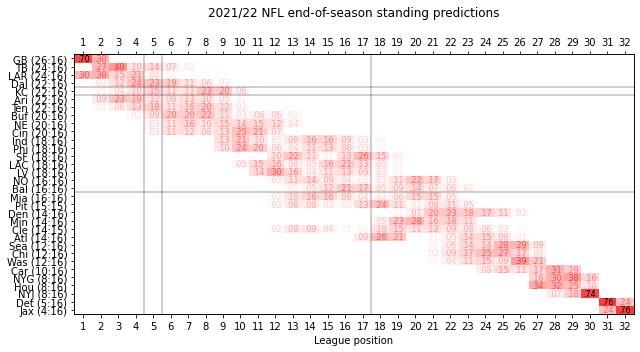

In [12]:
%matplotlib inline
plot(simulation_outputs)